In [1]:
import json
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = [12, 8]
matplotlib.rcParams.update({
    'font.size': 15,
    "xtick.color": "#333333",
    "ytick.color": "#333333",
    "axes.facecolor": "white",
    "axes.edgecolor": "darkgrey",
    "axes.labelcolor": "darkgrey",
})

In [2]:
with open(f'data/output/model_outputs_20210308071110.json', 'r') as stream:
    model_comparison = json.load(stream)

## read in + model

In [3]:
# read in
df = pd.read_csv('data/prepped/spotify_featured.csv')
ycolumn = 'target'
xcolumns = [c for c in df.columns if c != ycolumn]
seed = 99
test_size = 0.2

In [4]:
# model
selected_features = model_comparison['randomforest']['features'][:8]
X = df[selected_features].values
y = df[ycolumn].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
classifier = RandomForestClassifier(max_depth=7, min_samples_leaf=int(len(X)*0.01), n_estimators=100, random_state=seed)
classifier.fit(X_train, y_train)
y_predict = classifier.predict(X_test)
y_probas = classifier.predict_proba(X_test)[:, 1]
score = round(metrics.accuracy_score(y_test, y_predict), 7)

## profits

In [5]:
# business settings
revenuehit = 400000
revenueflop = 20000
marketcost = 120000
maxbudget = 50000000
market_flop_profit = revenueflop * 0.6 - marketcost
market_hit_profit = revenuehit * 0.6 - marketcost
nonmarket_flop_profit = revenueflop * 0.1
nonmarket_hit_profit = revenuehit * 0.1

In [6]:
# profit calcs

y_probas_sorted = sorted(y_probas, reverse=True)

y_test_profits = [p * market_hit_profit + (1-p) * market_flop_profit for p in y_probas_sorted]
y_test_profits_random = [0.5 * market_hit_profit + (0.5) * market_flop_profit for p in y_probas_sorted]

cum_profit = []
saldo_profit = 0
for p in y_test_profits:
    saldo_profit += p
    cum_profit.append(saldo_profit)
saldo_profit = 0
cum_profit_random = []
for p in y_test_profits_random:
    saldo_profit += p
    cum_profit_random.append(saldo_profit)

In [7]:
# budgets
maxbudget_ntracks = int(maxbudget / marketcost)
maxbudget_model_profit = cum_profit[maxbudget_ntracks]
maxbudget_random_profit = cum_profit_random[maxbudget_ntracks]

# model
optimalmodel_ntrack = cum_profit.index(max(cum_profit))
optimalmodel_model_profit = max(cum_profit)
optimalmodel_random_profit = cum_profit_random[optimalmodel_ntrack]

# random
optimalrandom_ntrack = cum_profit_random.index(max(cum_profit_random))
optimalrandom_model_profit = max(cum_profit_random)
optimalrandom_random_profit = cum_profit[optimalrandom_ntrack]

In [15]:
maxbudget_ntracks

416

## Curve

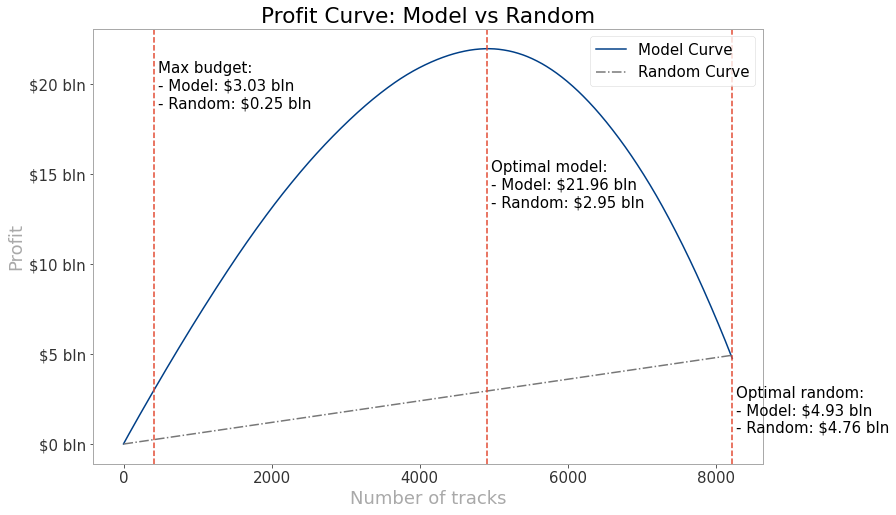

In [14]:
def billions(x, pos):
    return '$%1.f bln' % (x * 1e-7)
formatter = FuncFormatter(billions)

fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(formatter)

# curves
plt.plot(cum_profit, color='#003F87', label='Model Curve')
plt.plot(cum_profit_random, color='#777', label='Random Curve', linestyle='-.')

# max budget
plt.axvline(x=maxbudget_ntracks, linestyle='--')
plt.text(maxbudget_ntracks+50, max(cum_profit)*0.85, f'Max budget: \n- Model: ${round(maxbudget_model_profit / 10000000, 2)} bln\n- Random: ${round(maxbudget_random_profit / 10000000, 2)} bln')

# optimal model
plt.axvline(x=optimalmodel_ntrack, linestyle='--')
plt.text(optimalmodel_ntrack+50, max(cum_profit)*0.6, f'Optimal model: \n- Model: ${round(optimalmodel_model_profit / 10000000, 2)} bln\n- Random: ${round(optimalmodel_random_profit / 10000000, 2)} bln')

# optimal random
plt.axvline(x=optimalrandom_ntrack, linestyle='--')
plt.text(optimalrandom_ntrack+50, max(cum_profit)*0.03, f'Optimal random: \n- Model: ${round(optimalrandom_model_profit / 10000000, 2)} bln\n- Random: ${round(optimalrandom_random_profit / 10000000, 2)} bln')

plt.title('Profit Curve: Model vs Random')
plt.xlabel('Number of tracks')
plt.ylabel('Profit')
plt.legend()
plt.show()